In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Read Data**

In [2]:
url = 'https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_2/D3.csv'

dataframe = pd.read_csv(url)

In [3]:
dataframe.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


**Triple Exponential Smoothing without inbuilt function**

In [4]:
alpha_array = [0.5,0.7,0.9]
gamma_array = [0.06,0.04,0.02]
beta_array = [0.4,0.7,0.95]

#Initial components
 #level
s1 = dataframe['Passengers'][0] 

 #Trend
season_len = 12            
sum = 0.0
for i in range(season_len):
  sum += float(dataframe['Passengers'][i+season_len] - dataframe['Passengers'][i]) / season_len
  b1 = sum / season_len


 #Seasonal
seasonals = {}
season_averages = []
n_seasons = int(len(dataframe['Passengers'])/season_len)
# compute season averages
for j in range(n_seasons):
  season_averages.append(np.sum(dataframe['Passengers'][season_len*j:season_len*j+season_len])/float(season_len))
# compute initial values
for i in range(season_len):
  sum_of_vals_over_avg = 0.0
  for j in range(n_seasons):
    sum_of_vals_over_avg += dataframe['Passengers'][season_len*j+i]-season_averages[j]
  seasonals[i] = sum_of_vals_over_avg/n_seasons

**Function for triple exponential smoothing**

In [64]:
def dataset_with_interval(dataset):
  
  forecasted_list=[]
  mse_list = []
  complete_fc_val_list=[]
  for alpha in alpha_array:
    for gamma in gamma_array:
      for beta in beta_array:
        s = [s1]
        b = [b1]
        f = []
        n_pred = 24
        future_forecast = []
        #multiplicative 
        for i in range(len(dataset)+n_pred): 

          if i >= len(dataset): # we are forecasting
            m = i - len(dataset) + 1
            future_forecast.append((st + m*bt)*seasonals[i%season_len])  

          if (i<(len(dataset)-1)):
            st = alpha*(dataset[i+1]/seasonals[i%season_len]) + ((1-alpha)*(s[i]+b[i]))
            s.append(st)       
            bt = gamma*(s[i+1]-s[i]) + (1-gamma)*b[i] 
            b.append(bt)   
            seasonals[i%season_len] = beta*(dataset[i+1]/s[i+1]) + (1-beta)*seasonals[i%season_len]
            ft = (st+bt)*seasonals[i%season_len]
            f.append(ft)

        f.insert(0,s1)
        fc_s = f.copy()
        forecasted_list.append(f[-1])
        complete_fc_val_list.append(fc_s)

        cp_df = dataset.copy()
        cp_df = np.c_[ cp_df, f ] 
        error_array = cp_df[:,0] - cp_df[:,1]
        cp_df = np.c_[ cp_df, error_array ]
        sqer_arr = (cp_df[:,2])**2
        cp_df = np.c_[cp_df,sqer_arr]

        MSE = np.sum(cp_df[1:len(dataset),3])/(len(cp_df)-1) 
        mse_list.append(MSE)

  return mse_list,forecasted_list,complete_fc_val_list,future_forecast

**Different interval data array**

In [26]:
data= dataframe.values
dataset_array = [data[0::1][:,1],data[0::2][:,1],data[0::4][:,1],data[0::8][:,1],data[0::12][:,1],data[0::24][:,1]]


**Different interval time array**

In [27]:
time_array = []
for d in dataset_array:
  t = range(d.shape[0])
  time_array.append(t)

**Function call for MSE and prediction calculations**

In [65]:
final_mse_list = []
final_forecasted_list = []
final_fc_val_list = []
future_forecast_list = []
for df in dataset_array:
  mse_list,forecasted_list,complete_fc_val_list,future_forecast = dataset_with_interval(df)
  final_mse_list.append(mse_list)
  final_fc_val_list.append(complete_fc_val_list)
  final_forecasted_list.append(forecasted_list)
  future_forecast_list.append(future_forecast)

In [29]:
min_idx=[]
for minval in final_mse_list: 
  minidx = minval.index(min(minval))
  min_idx.append(minidx)

In [30]:
interval_arr = [1,2,4,8,12,24]

**Plotting function for predicted values ad actual values**

In [31]:
def plotting_function(fc_val,data_val,time_val,interval_val):
  fig = plt.gcf()
  plt.plot(time_val,data_val,color='g',label='Original')
  plt.plot(time_val,fc_val,color='r',label='Forcasted')
  fig.set_size_inches(12,8)
  plt.legend()
  plt.xlabel('Time (in months)')
  plt.ylabel('Passengers')
  plt.title('Prediction at '+str(interval_val)+' month interval at the least MSE')
  plt.figure()
  plt.close

**Plotting of predicted values and actual values for different intervals**

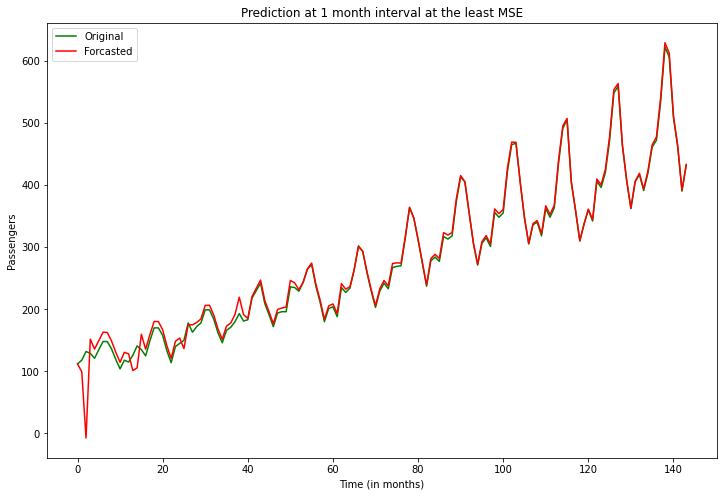

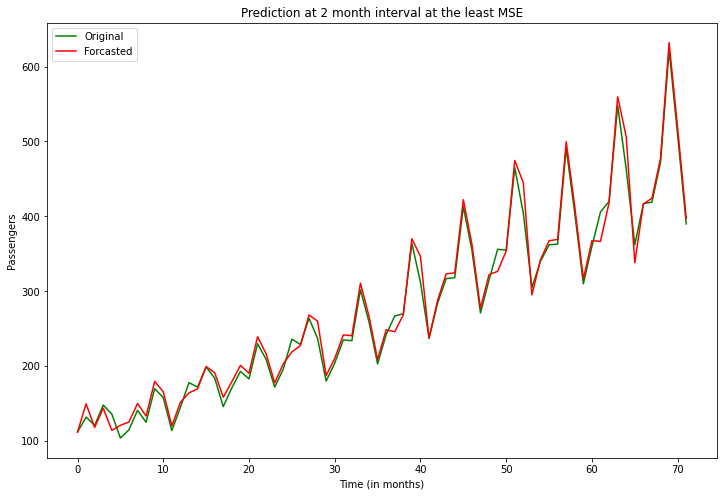

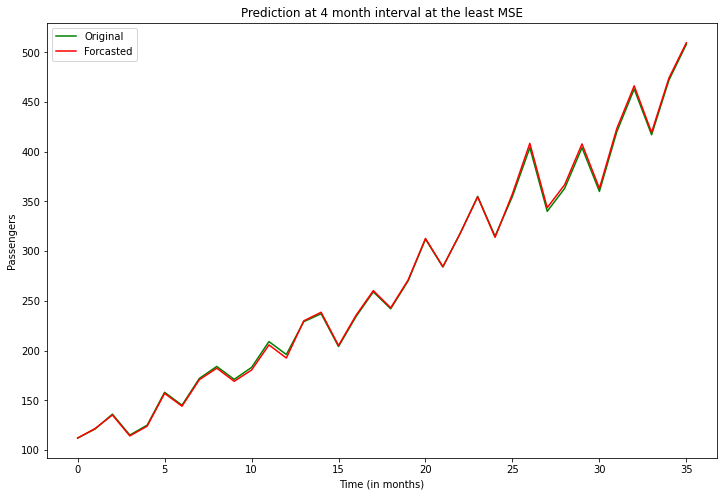

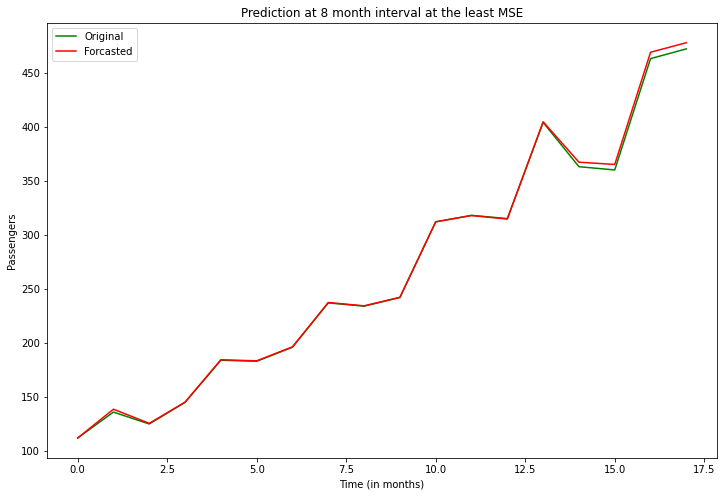

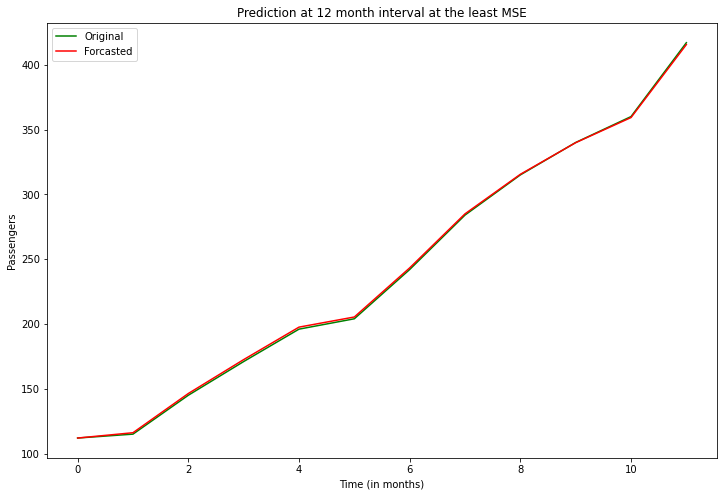

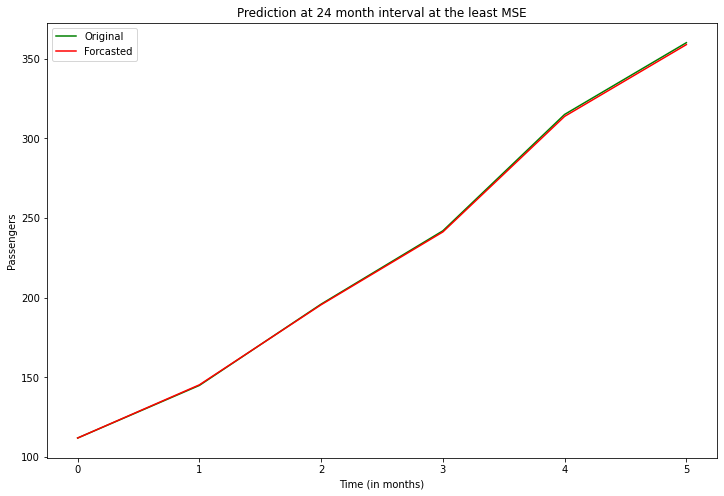

<Figure size 432x288 with 0 Axes>

In [32]:
for fc_idx in range(6):
  plotting_function(final_fc_val_list[fc_idx][min_idx[fc_idx]],dataset_array[fc_idx],time_array[fc_idx],interval_arr[fc_idx])  

**Table of Least MSE value for each interval**

In [33]:
from tabulate import tabulate

tab_array = []
for n in range(6):
  tab = [(interval_arr[n]),final_mse_list[n][min_idx[n]]]
  tab_array.append(tab)

table = tabulate(tab_array, headers=['interval(in months)', 'Least MSE'], tablefmt='orgtbl')

print(table)

|   interval(in months) |   Least MSE |
|-----------------------+-------------|
|                     1 |  198.726    |
|                     2 |  185.515    |
|                     4 |    4.75961  |
|                     8 |    7.02346  |
|                    12 |    1.36403  |
|                    24 |    0.752448 |


**Plotting of MSE at different intervals**

In [34]:

def mse_plotting_func(inter_val,mseval):
  fig = plt.gcf()
  ax = fig.add_axes([0,0,1,1])
  rects = ax.bar(inter_val,round(mseval,2),color='b')
  for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom') 
  fig.set_size_inches(12,8)
  plt.xlabel('Interval(in months)')
  plt.ylabel('MSE')
  plt.title('MSE VS Interval')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


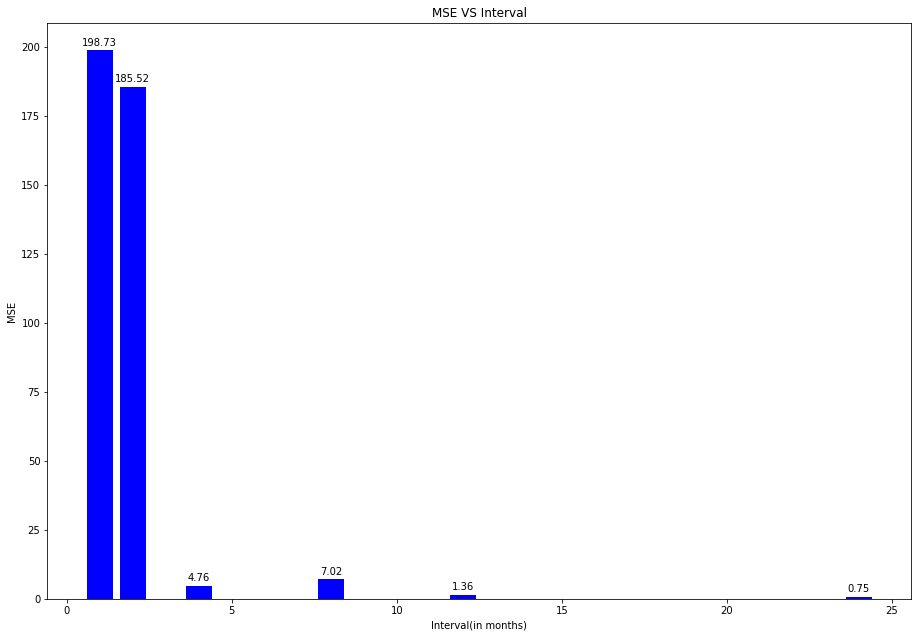

In [35]:
for idx in range(6):
  mse_plotting_func(interval_arr[idx],final_mse_list[idx][min_idx[idx]])

**Comparing forecasted values with inbuilt function**

In [36]:
#using inbuilt function
model = ExponentialSmoothing(dataframe['Passengers'])
fit1 = model.fit(smoothing_level=0.9, smoothing_slope=.02, smoothing_seasonal=0.95).forecast()
print('forcasted value using inbuilt function for alpha=0.9, gamma=0.02, beta=0.95 : ',float(fit1))


forcasted value using inbuilt function for alpha=0.9, gamma=0.02, beta=0.95 :  428.5668665454442


In [37]:
print('forcasted value for using own function alpha=0.9, gamma=0.02, beta=0.95 : ',final_forecasted_list[0][min_idx[0]])      #our value

forcasted value for using own function alpha=0.9, gamma=0.02, beta=0.95 :  433.0001949995716


In [50]:
from sklearn.metrics import mean_squared_error

dataframe['pred_val'] = model.fit(smoothing_level=0.9, smoothing_slope=.02, smoothing_seasonal=0.95,optimized=False).fittedvalues.shift(0)

MSE = mean_squared_error(dataframe.pred_val.dropna(),dataframe.Passengers)

In [51]:
print('MSE (inbuilt function): ',MSE)
print('MSE (own function): ',final_mse_list[0][min_idx[0]])

MSE (inbuilt function):  1206.599753555369
MSE (own function):  4.988045632596854


In [52]:
print('Difference in error: ',abs(final_mse_list[0][min_idx[0]]-MSE))

Difference in error:  1201.6117079227722


**Prediction of futuristic 24 months**

In [66]:
print('futuristic 24 months prediction: ',future_forecast_list[0])

futuristic 24 months prediction:  [411.524320795459, 463.21779364429483, 453.5892778145458, 455.1826906849401, 517.7071267409679, 583.1900749349829, 584.0988538574807, 509.5931634742454, 458.629288810936, 402.9660093656222, 455.93071218042553, 471.5683264802209, 436.2107459132683, 490.8669770414859, 480.5297361212191, 482.08463700557417, 548.1543999812587, 617.3212401705176, 618.1172947204567, 539.1289767851038, 485.08348372421904, 426.09829965830943, 481.97883686522914, 498.38219531831095]


In [62]:
model = ExponentialSmoothing(dataframe['Passengers']).fit(smoothing_level=0.9, smoothing_slope=.02, smoothing_seasonal=0.95).forecast(24)
print('futuristic 24 months prediction: ',model)

futuristic 24 months prediction:  144    428.566867
145    428.566867
146    428.566867
147    428.566867
148    428.566867
149    428.566867
150    428.566867
151    428.566867
152    428.566867
153    428.566867
154    428.566867
155    428.566867
156    428.566867
157    428.566867
158    428.566867
159    428.566867
160    428.566867
161    428.566867
162    428.566867
163    428.566867
164    428.566867
165    428.566867
166    428.566867
167    428.566867
dtype: float64


In [67]:
total_fc_data = final_fc_val_list[0][min_idx[0]].copy()
total_fc_data.extend(future_forecast_list[0])
print(total_fc_data)

[112, 121.0411708417861, 132.52231004543196, 127.81410712406294, 118.7852209873033, 131.58115460552284, 143.75721175240403, 143.60087888311628, 132.30905486906707, 116.27485363790574, 101.8856727636119, 115.85103705866699, 113.06242648255434, 124.33889343314164, 140.58288504332606, 134.8627964418796, 124.53866365259613, 147.65995850608493, 168.04351993388525, 167.85315580094866, 155.99088082329507, 131.57029310458032, 112.88122723938024, 138.75146985093377, 144.11209349635408, 149.40423926843076, 178.26722206907894, 164.02708116676112, 172.94257305672517, 179.38358900567118, 199.74123491601256, 199.03570988695677, 183.59545780058687, 161.54744795310168, 145.7240984320296, 166.0000560636559, 171.05156096519022, 180.1211455085354, 193.85728323459583, 182.1257047984961, 184.3718658414152, 219.4856258113625, 232.0419472024641, 243.50933944563636, 210.18471368460814, 191.51272040477426, 172.42238376160353, 194.63530705421454, 196.70838219158023, 196.6775295835519, 236.88491086969967, 236.58

In [71]:
total_time_array = (range(0,168))

range(0, 168)


<Figure size 432x288 with 0 Axes>

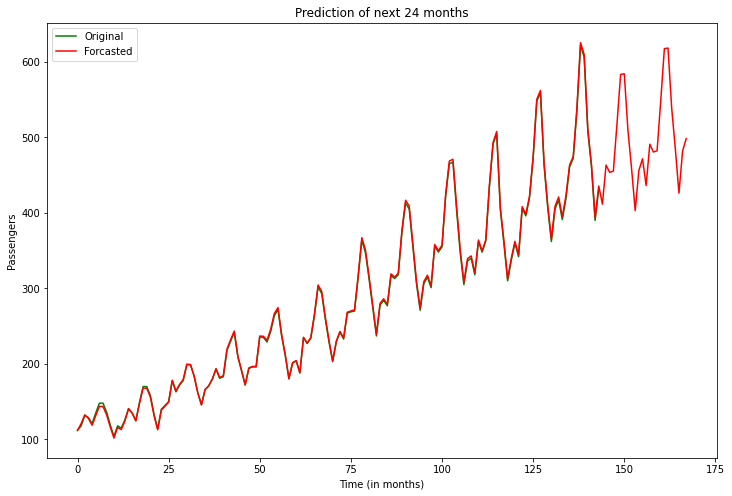

<Figure size 432x288 with 0 Axes>

In [72]:
fig = plt.gcf()
plt.plot(time_array[0],dataframe['Passengers'],color='g',label='Original')
plt.plot(total_time_array,total_fc_data,color='r',label='Forcasted')
fig.set_size_inches(12,8)
plt.legend()
plt.xlabel('Time (in months)')
plt.ylabel('Passengers')
plt.title('Prediction of next 24 months')
plt.figure()